# Building a Dense Neural Network
In this notebook I will build my own dense neural network for 2-class prediction, implementing
1. Model architecture
2. Parameter initializaion
3. Forward propagation
4. Loss function computation
5. Backward propagation
6. Gradient descent parameter update
7. Training algorithm
8. Prediction

## Import Python modules

In [121]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from dnn_utils import sigmoid, visualize_decision_boundary
from sklearn.metrics import accuracy_score


import dnn_utils

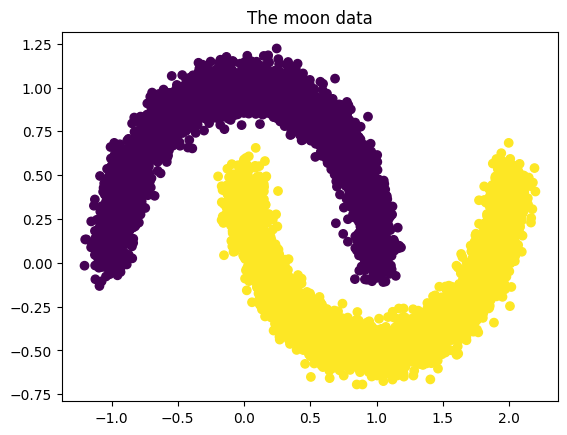

In [122]:
## Load the dataset
X, Y = datasets.make_moons(10000, noise=0.07, random_state=24 )
plt.scatter(X[:,0],X[:,1], c=Y)
plt.title('The moon data')
plt.show();

From the plot above, it can be seen clearly that the classes of this dataset cannot be separated by a linear decision boundary, so a logistic regression would do quite bad on it. 

Let us take a look at the data dimensions.

In [123]:
# Print the data dimensions
print(' input dimensions: {}'.format(X.shape))
print('output dimensions: {}'.format(Y.shape))

 input dimensions: (10000, 2)
output dimensions: (10000,)


## Prerequisite: Logistic regression
To have an appropriate benchmark model a logistic regression should be fit to the data. Note that a logistic regression possesses a linear decision boundary. For the data shown above this will be problematic. 


The accuracy for our logistic regression is: 0.8872


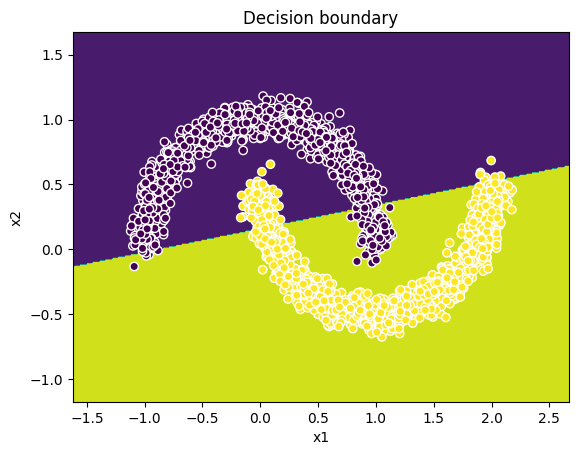

In [124]:
#===========#
# YOUR CODE # ~ 4 lines
#===========#

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y,random_state = 42)

logreg = LogisticRegressionCV().fit(X_train,y_train)

y_pred=logreg.predict(X_test)

visualize_decision_boundary(X_test,y_test, lambda x: logreg.predict(x))

print(f"The accuracy for our logistic regression is: {accuracy_score(y_test, y_pred)}")

## 1. Model architecture
For each layer the number of parameters are defined by their input and ouput, respectively. The dense neural network has the following layers:

1. input layer
2. hidden layer
3. output layer

<img src="../images/artificial_network_architecture_dnn.png" alt="" width="400"/>



In [125]:
def model_architecture(X,Y, n_hidden=10):
    """
    Defines the DNN model architecture
    
        Args:
        X: feature vector with shape (n_samples, n_input)
        Y: true target of shape (n_samples, 1)   
        n_hidden: size of the hidden layer (defined by user)    
        
        Returns:
        arch: model architecture with sizes of layers in a dict
    """
    arch = {}

    arch['n_input']= X.shape[1]
    arch['n_hidden']= n_hidden
    arch['n_output']= 1


    return arch

In [126]:
neural_network = model_architecture(X_train,y_train, n_hidden=10)

## 2. Parameter initialization
Parameter initialization in neural networks is a delicate issue as in contrast to other machine learning methods we cannot set starting weights to zero (it does work for the bias though). The reason for this is that starting from zero will give uninformative gradients and your model will not improve. 

There are many different ways of parameter initialization in neural network literature. Some of them are used more often than others. Here we will use random weigh initialization, i.e. we will initialize all weights randomly with mean zero and a certain variance (if too low gradients will again tend to vanish). 

**_Info_**: Two other initializations worth noting are _He initialization_ and _Xavier initialization_ also named _Glorot initialization_ (especially in multiple software packages).

From the mathematical model it should become clear which parameters exist and must be initialized:

$$
\begin{align}
\mathbf{z}^{[1]}_i&=\mathbf{W}^{[1]}\mathbf{x}_i+\mathbf{b}^{[1]}\\
\mathbf{a}^{[1]}_i&=\tanh(\mathbf{z}^{[1]}_i)\\
\mathbf{z}^{[2]}_i&=\mathbf{W}^{[2]}\mathbf{a}^{[1]}_i+\mathbf{b}^{[2]}\\
\mathbf{a}^{[2]}_i&=\text{sigmoid}(\mathbf{z}^{[2]}_i)
\end{align}
$$

A threshold then determines which class is assigned to the $i$th instance:

$$
\hat{y}_i=\begin{cases}
1&a^{[2]}_i>0.5\\
0&a^{[2]}_i\leq0.5\\
\end{cases}
$$

The usual way how neural networks of any kind are built is to first define the network architecture (i.e. `n_inputs`, `n_hidden`, and `n_output`). Then step (2.) from [above](#2-parameter-initialization) (parameter initialization) and a loop through steps (3.)-(5.). In many programs you can find some wrapping function that holds steps  (1.)-(5.) and trains your whole network. After training you can use the trained model parameters for prediction.



In [127]:
def init_params(n_input,n_hidden,n_output):
    """
        Args:
        n_input:  input layer size
        n_hidden: hidden layer size
        n_output: output layer size
        
        Returns:
        params: dict holding the network parameters:
            W1: weight matrix of hidden layer
            b1: bias of hidden layer
            W2: weight matrix of output layer
            b2: bias of output layer
    """
    # Seed serves for output checks
    np.random.seed(42)
    
    
    params = {}

    params['W1']= np.random.uniform(-1, 1, (n_hidden, n_input))
    params['b1']= np.zeros((n_hidden, 1))
    params['W2']= np.random.uniform(-1, 1, (n_output, n_hidden))
    params['b2']= np.zeros((n_output, 1))


    assert (params['W1'].shape==(n_hidden, n_input))
    assert (params['b1'].shape==(n_hidden, 1))
    assert (params['W2'].shape==(n_output, n_hidden))
    assert (params['b2'].shape==(n_output, 1))
    
    
    return params

In [128]:
parameters = init_params(neural_network['n_input'], neural_network['n_hidden'], neural_network['n_output'])

parameters

{'W1': array([[-0.25091976,  0.90142861],
        [ 0.46398788,  0.19731697],
        [-0.68796272, -0.68801096],
        [-0.88383278,  0.73235229],
        [ 0.20223002,  0.41614516],
        [-0.95883101,  0.9398197 ],
        [ 0.66488528, -0.57532178],
        [-0.63635007, -0.63319098],
        [-0.39151551,  0.04951286],
        [-0.13610996, -0.41754172]]),
 'b1': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 'W2': array([[ 0.22370579, -0.72101228, -0.4157107 , -0.26727631, -0.08786003,
          0.57035192, -0.60065244,  0.02846888,  0.18482914, -0.90709917]]),
 'b2': array([[0.]])}

## 3. Forward propagation
Forward propagation is the step through the network model from input to output. 

>__Exercise__: Complete the `forward_prop()` function below to compute the forward step through the network. You can use the `sigmoid()` function from the `dnn_utils.py`. 

**_Info_**: The `forward_prop()` function returns next to the model output a `cache` that holds the layer vectors for the backpropagation step. By caching these values the backpropagation step does not need to recalculate them - this saves computation time. 

In [129]:
def forward_prop(X, params):
    """
        Args:
        X:      input data (NxD) 
        params: model parameters as a dictionary
        
        Returns:
        A:     activations of output layer
        cache: dict containing activations A and layer output Z                
    """
    
    # Forward propagation
    
    Z1 = np.dot(params['W1'], X.T) + params['b1'] 
    A1 = np.tanh(Z1)
    Z2 = np.dot(params['W2'], A1) + params['b2']
    A2 = sigmoid(Z2)

    
    assert(A2.shape==(1, X.shape[0]))
       
    cache = {'Z1' : Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    
    return A2, cache

In [130]:
A2, cache = forward_prop(X_train, parameters)
A2
cache

{'Z1': array([[-0.29069579,  0.01850565, -0.65054029, ..., -0.59235915,
          0.54260863,  0.27000196],
        [ 0.93577108,  0.06557047,  0.7441947 , ...,  0.30660879,
          0.41566212,  0.50775766],
        [-1.47195937, -0.11839065, -1.00611663, ..., -0.28729855,
         -0.91732319, -0.96647957],
        ...,
        [-1.36084498, -0.1093372 , -0.93142367, ..., -0.26710021,
         -0.84606469, -0.89224126],
        [-0.74346439, -0.04376571, -0.68111251, ..., -0.35011333,
         -0.18631083, -0.3117607 ],
        [-0.35133757, -0.03848752, -0.12980116, ...,  0.06223089,
         -0.3957068 , -0.3432366 ]]),
 'A1': array([[-0.28277509,  0.01850354, -0.57203357, ..., -0.53159021,
          0.49496006,  0.26362666],
        [ 0.73327324,  0.06547666,  0.63167281, ...,  0.29734885,
          0.39326972,  0.46819623],
        [-0.89995056, -0.1178406 , -0.76415104, ..., -0.2796465 ,
         -0.72462863, -0.74715318],
        ...,
        [-0.8765889 , -0.10890358, -0.7312

## Loss function computation
After the forward propagation the network output is used in the loss function to evaluate the model's expressivity. In this case we use the _log-loss_ function (this is actually the 2-class form of the _cross-entropy_):

$$
\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})=-\frac{1}{N}\sum_{i=1}^N\left(y_i\log(a^{[2]}_i)+(1-y_i)\log(1-a^{[2]}_i)\right)
$$

where $N$ is the number of samples `n_samples` and $a_i^{[2]}$ denotes the $i$ th element of the activation of the output layer, $\mathbf{a}^{[2]}$.



In [131]:
def logloss(A, Y):
    """
    Computes the logloss (cross-entropy)
    
        Arguments:
        A:      output activations
        Y:      true target of shape (n_samples,)

        Returns:
        logloss: cost of the actual parameter choice
    """
    
    # Implement here the loss function
  
    g = np.multiply(Y, np.log(A)) + np.multiply((1-Y), np.log(1-A))
    loss = -1 * np.sum(g) / len(Y)
    
    
    # Squeeze the dimensions of the scalar-valued vector
    loss = float(np.squeeze(loss))
 
    
    return loss

In [132]:
loss = logloss(A2, y_train)
loss

1.1414095916492564

## Backward propagation 
The backward propagation propagates the error back into the network by using the chain rule for derivatives. What is needed are the derivatives of the loss function towards each parameter, i.e. all weights and biases. Backpropagation is usually the most demanding part of programming a deep learning network. 

The following derivatives need to be implemented: 

$$
\begin{align}
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}&=(a^{[2]}_i-y_i)\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{W}^{[2]}}&=\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}\mathbf{a}^{[1]T}_i\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial b^{[2]}}&=\sum_{i=1}^N\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{z}^{[1]}_i}&=\mathbf{W}^{[2]T}\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}*(\mathbf{1}-(\mathbf{a}^{[1]}_i)^2)\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{W}^{[1]}}&=\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{z}^{[1]}_i}\mathbf{x}_i^T\\
\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial \mathbf{b}^{[1]}}&=\sum_{i=1}^N\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{z}^{[1]}_i}
\end{align}
$$
where $T$ stands for the transposed of a vector or matrix, respectively, and $\mathbf{1}$ is a vector of ones. The $*$-operator denotes a convolution, i.e. an elementwise multiplication for vectors and matrices.

**_Info_**: You might note that you have to derive also the activation functions $\phi()=\{\tanh,\text{sigmoid}\}$ to step back from the activations to the parameters. For $\phi=\tanh$, $\phi^{\prime}(\mathbf{z}^{[1]})=1-(\mathbf{a}^{[1]})^2$. 

>The derivative of the loss function towards the second layer output, $\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial z^{[2]}_i}=(a^{[2]}_i-y_i)$ in vector form is $A2-Y$)

In [133]:
def backward_prop(X, Y, params, cache):
    """
        Args:
        X:      feature matrix with shape (n_samples, n_inputs)
        Y:      true target of shape (n_samples,1)
        params: model parameters as a dictionary
        cache:  cached layer outputs (Z1,A1,Z2,A2)
        
        Returns:
        grads: dict of gradients 
    """
    
    # Normalize the parameter gradients with this batch size.
    n_samples = X.shape[0]
    
    # Backward propagation: 

    dZ2 = (cache['A2'] - Y) 
    dW2 = np.dot(dZ2, cache['A1'].T) / n_samples
    db2 = np.sum(dZ2, axis=1, keepdims=True) / n_samples

    dZ1 = np.multiply(np.dot(params['W2'].T, dZ2), 1 - np.power(cache['A1'], 2))
    dW1 = np.dot(dZ1, X) / n_samples
    db1 = np.sum(dZ1, axis=1, keepdims=True) / n_samples
    
    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    
    return grads

In [134]:
grads = backward_prop(X_train, y_train, parameters, cache)

## 6. Gradient descent parameter update
The parameter update in gradient descent for neural networks is actually similar to the general one: 

$$
\begin{align}
\mathbf{W}^{[j]}_{t+1}&=\mathbf{W}^{[j]}_t - \alpha\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{W}^{[j]}}\big|_t\\
\mathbf{b}^{[j]}_{t+1}&=\mathbf{b}^{[j]}_{t} - \alpha\frac{\partial\mathcal{L}(\mathbf{y},\mathbf{a}^{[2]})}{\partial\mathbf{b}^{[j]}}\big|_t
\end{align}
$$

where $\alpha$ is the learning rate (step-size of Gradient Descent). A learning rate too small increases training time and a learning rate too large lets the algorithm diverge. So the learning rate is a hyperparameter to be cared for. It is one og the most important hyperparameters in optimization of neural networks. In theory the learning rate needs to decrease sufficiently fast to ensure that the Gradient Descent converges.  




In [135]:
def update_params(params, grads, learning_rate=1.5):
    """
        Args:
        params:        model parameters as a dictionary
        grads:         gradients of parameters as a dictionary
        learning_rate: gradient descent step-size
        
        Returns:
        params: updated model parameters as a dictionary
    """
    
    # Update all parameters
    W1 = params['W1'] - learning_rate * grads['dW1']
    b1 = params['b1'] - learning_rate * grads['db1']
    W2 = params['W2'] - learning_rate * grads['dW2']
    b2 = params['b2'] - learning_rate * grads['db2']
    
    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return params

In [136]:
parameters = update_params(parameters, grads, learning_rate=1.2)


## 7. Training algorithm
The traning algorithm puts all the steps together. Here you build your complete neural network. Gradient descent is used here in _batch_ form, i.e. we use at each update __all__ samples in the data set. The maximum number of iterations defines how often the update is made. 


In [148]:
def train_dnn(X, Y, n_hidden, max_iter=1000, learning_rate=1.2, verbose=False):
    """
    Trains a dense neural network with 'n_hidden' hidden layers.
    
        Args:
        X:             feature vector with shape (n_samples,n_input)
        Y:             true target of shape (n_samples,1)
        n_hideen:      number of hidden layers
        learning_rate: gradient descent step-size
        max_iter:      maximum number of iterations of gradient descent
        verbose:       print info during optimization
        
        Returns:
        params: dict of trained model parameters (can be used for prediction)        
    """
    
    # Initialize parameters of the model
    model_arch = model_architecture(X, Y, n_hidden)
    params = init_params(model_arch['n_input'], model_arch['n_hidden'], model_arch['n_output'])
    
    # Gradient descent 
    # Loop until iterator is exhausted
    for i in range(max_iter):
        
        # 1. Forward propagation
        A2, cache = forward_prop(X, params)
        
        # 2. Calculate loss
        loss = logloss(A2, Y)
        
        # 3. Backward propagation
        grads = backward_prop(X, Y, params, cache)
        
        # 4. Parameter Update
        params = update_params(params, grads, learning_rate)
        
        # Gradient descent info
        if verbose:
            if i % 50 == 0: 
                print('Loss after %i iterations: %f' % (i+1, loss))
            
    return params

In [149]:
params = train_dnn(X_train, y_train, n_hidden=10, verbose=True)


Loss after 1 iterations: 1.141410
Loss after 51 iterations: 0.243077
Loss after 101 iterations: 0.180106
Loss after 151 iterations: 0.112262
Loss after 201 iterations: 0.078393
Loss after 251 iterations: 0.058597
Loss after 301 iterations: 0.045279
Loss after 351 iterations: 0.035809
Loss after 401 iterations: 0.028925
Loss after 451 iterations: 0.023811
Loss after 501 iterations: 0.019922
Loss after 551 iterations: 0.016903
Loss after 601 iterations: 0.014519
Loss after 651 iterations: 0.012610
Loss after 701 iterations: 0.011064
Loss after 751 iterations: 0.009799
Loss after 801 iterations: 0.008755
Loss after 851 iterations: 0.007884
Loss after 901 iterations: 0.007152
Loss after 951 iterations: 0.006531


## 8. Prediction
In prediction the trained parameters are used to calculate a network output and a threshold makes a class assignment. Make sure that you reuse a function you already programmed before. 

>__Exercise__: Complete the `predict()` function for your neural network. Use a threshold of 0.5.

In [150]:
def predict(X, params):
    """
    Predicts targets with trained model 
    
        Args:
        X: feature vector with shape (n_samples, n_input)
        params: model parameters as a dictionary
        
        Returns:
        preds: model predictions 
    """
    
    # DNN gives out probabilities 
    # A threshold defines how results are assigned to classes
    A2, cache = forward_prop(X, params)
    preds = (A2 > 0.5)
    
    return preds

In [156]:
# Predict values
predicted = predict(X_train, params).squeeze()



print('Predictions: ')
print('------------')
print('Train accuracy: %f' % accuracy_score(y_train, predicted))

Predictions: 
------------
Train accuracy: 1.000000


## Train your neural network on the data

In [158]:
# Train the network on the train data
params_trained = train_dnn(X_train, y_train, n_hidden=4, verbose=True)

# Print the metrics 
preds_train = predict(X_train, params_trained).squeeze()
preds_test = predict(X_test, params_trained).squeeze()


print('Training results: ')
print('-----------------')
print('train acc.: %f' % accuracy_score(y_train, preds_train))
print(' test acc.: %f' % accuracy_score(y_test, preds_test))

Loss after 1 iterations: 0.972619
Loss after 51 iterations: 0.252458
Loss after 101 iterations: 0.250288
Loss after 151 iterations: 0.248835
Loss after 201 iterations: 0.245550
Loss after 251 iterations: 0.213374
Loss after 301 iterations: 0.134184
Loss after 351 iterations: 0.078886
Loss after 401 iterations: 0.048713
Loss after 451 iterations: 0.032601
Loss after 501 iterations: 0.023554
Loss after 551 iterations: 0.018052
Loss after 601 iterations: 0.014456
Loss after 651 iterations: 0.011965
Loss after 701 iterations: 0.010157
Loss after 751 iterations: 0.008796
Loss after 801 iterations: 0.007741
Loss after 851 iterations: 0.006901
Loss after 901 iterations: 0.006220
Loss after 951 iterations: 0.005657
Training results: 
-----------------
train acc.: 1.000000
 test acc.: 1.000000


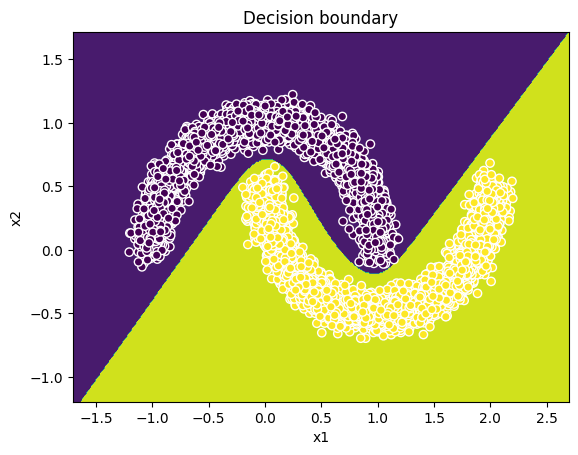

In [159]:
# Visualize the decision boundaries
from dnn_utils import visualize_decision_boundary
visualize_decision_boundary(X, Y, lambda x: predict(x, params_trained))